#### Imports

In [71]:
import textwrap
import tempfile

from pathlib import Path

from file_handling.pipeline_input_handling.pipeline_input_file_manager import PipelineInputFileManager

from file_handling.pipeline_configuration_handling.pipeline_configuration_file_manager import \
    PipelineConfigurationFileManager

from pipeline_entities.large_data_classes.pipeline_configuration.pipeline_configuration_data import PipelineConfigurationData
from pipeline_entities.large_data_classes.pipeline_configuration.pipeline_configuration import PipelineConfiguration

from pipeline_entities.large_data_classes.pipeline_input.pipeline_input_data import PipelineInputData
from pipeline_entities.large_data_classes.pipeline_input.pipeline_input import PipelineInput

from pipeline_entities.pipeline.pipeline import Pipeline
from pipeline_entities.pipeline.pipeline_builder.pipeline_builder import PipelineBuilder
from pipeline_entities.pipeline_execution.output.pipeline_component_execution_report import \
    PipelineComponentExecutionReport

from pipeline_entities.pipeline_execution.pipeline_manager.pipeline_manager import PipelineManager

from setup_manager.internal_logic_setup_manager import InternalLogicSetupManager

import matplotlib.pyplot as plt

#### Setup

In [72]:
InternalLogicSetupManager.setup()

#### Pipeline configuration

In [73]:
pipeline_configuration_file_content: bytes = textwrap.dedent("""\
    name="Runtime comparison between Aitken-Neville variants"
    supported_program_version=Version(\"1.0.0\")
    components=DirectionalAcyclicGraph(\"\"\"
        0=Base Input
        1=Equidistant Node Generator
            predecessors=["0"]
        2=Function Expression Input
            predecessors=["1"]
        3=Interpolation Values Evaluator
            predecessors=["2"]
        4=Aitken Neville Interpolation
           predecessors=["3"]
        5=Interpolant Evaluator
           predecessors=["4"]
        6=Aitken Neville Evaluator
           predecessors=["3"]
        \"\"\")
    extra_value=True

    runs_for_component_execution_time_measurements=10
    """).encode("utf-8")

In [74]:
temp_dir = tempfile.TemporaryDirectory()
temp_pipeline_configuration_file = Path(temp_dir.name + "/pipeline_configuration.ini")

with open(temp_pipeline_configuration_file, "wb") as f:
    f.write(pipeline_configuration_file_content)

In [75]:
pipeline_configuration_data: PipelineConfigurationData = PipelineConfigurationFileManager.load_from_file(temp_pipeline_configuration_file)
pipeline_configuration: PipelineConfiguration = PipelineConfiguration(pipeline_configuration_data)

#### Pipeline input

In [76]:
def generate_pipeline_input_file_content(node_count: int) -> bytes:
    return textwrap.dedent(f"""\
        name="PipelineInput {node_count}"
        data_type=jax.numpy.float32
        node_count={node_count}
        interpolation_interval=jax.numpy.array([-1, 1])
        interpolant_evaluation_points=jax.numpy.linspace(-1, 1, 1000)
        function_expression="sin(10*x)"
        sympy_function_expression_simplification=True
        """).encode("utf-8")


def generate_pipeline_input(node_count: int) -> PipelineInput:
    temp_pipeline_input_file: Path = Path(temp_dir.name + "/pipeline_input.ini")
    pipeline_input_file_content: bytes = generate_pipeline_input_file_content(node_count)

    with open(temp_pipeline_input_file, "wb") as f:
        f.write(pipeline_input_file_content)

    pipeline_input_data: PipelineInputData = PipelineInputFileManager.load_from_file(temp_pipeline_input_file)
    pipeline_input: PipelineInput = PipelineInput(pipeline_input_data)
    return pipeline_input

#### Pipeline generation

In [77]:
def generate_pipeline_manager(node_count: int) -> PipelineManager:
    pipeline_input: PipelineInput = generate_pipeline_input(node_count)
    pipeline: Pipeline = PipelineBuilder.build(pipeline_configuration, pipeline_input)
    pipeline_manager: PipelineManager = PipelineManager(pipeline)
    return pipeline_manager

#### Execution

In [78]:
def measure_runtime(node_count: int) -> tuple[float, float]:
    pipeline_manager: PipelineManager = generate_pipeline_manager(node_count)
    pipeline_manager.execute_all()

    aitken_neville_interpolation_core_report = pipeline_manager.get_component_execution_report("4")
    interpolant_evaluator_report = pipeline_manager.get_component_execution_report("5")
    aitken_neville_evaluator_report = pipeline_manager.get_component_execution_report("6")

    aitken_neville_interpolation_core_time: float = (
        aitken_neville_interpolation_core_report.average_component_execution_time + interpolant_evaluator_report.average_component_execution_time)
    aitken_neville_evaluator_time: float = aitken_neville_evaluator_report.average_component_execution_time

    return aitken_neville_interpolation_core_time, aitken_neville_evaluator_time

5101520253035404550556065707580859095

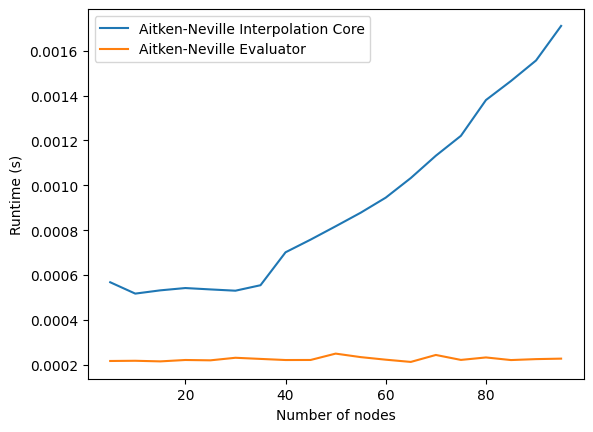

In [79]:
node_counts: list = [5 * i for i in range(1, 20)]
runtimes_interpolation_core = []
runtimes_evaluator = []

for node_count in node_counts:
    runtime_interpolation_core, runtime_evaluator = measure_runtime(node_count)
    runtimes_interpolation_core.append(runtime_interpolation_core)
    runtimes_evaluator.append(runtime_evaluator)
    print(node_count, end="")


plt.plot(node_counts, runtimes_interpolation_core, label="Aitken-Neville Interpolation Core")
plt.plot(node_counts, runtimes_evaluator, label="Aitken-Neville Evaluator")

plt.xlabel("Number of nodes")
plt.ylabel("Runtime (s)")
plt.legend()
plt.show()